In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [23]:
import nltk
from tethne.readers import zotero
import matplotlib.pyplot as plt
from helpers import normalize_token, filter_token
import numpy as np

# 1.2.2. Alternate corpus format

In the last few notebooks, we used a corpus that was generated from a Zotero collection. We read in our metadata from a Zotero RDF/XML document. Sometimes we either don't have access to additional metadata, or simply don't need it for our analysis. A very simple way to encode metadata is to include it in the file name. This isn't a very robust strategy, but for certain use-cases it does the job.

In [7]:
text_root = '../../data/SystemsBiology'
documents = nltk.corpus.PlaintextCorpusReader(text_root, '.+.txt')

In this corpus, the publication year is encoded as the first four characters of the filename. For examples:

In [9]:
documents.fileids()[0]

'2003_1.txt'

So when we generate our conditional distributions, we can simply convert those first four characters to an integer.

In [10]:
int(documents.fileids()[0][:4])

2003

In [12]:
word_counts_over_time = nltk.ConditionalFreqDist([
        (int(fileid[:4]), normalize_token(token))
         for fileid in documents.fileids()
         for token in documents.words(fileids=[fileid])
         if filter_token(token)
    ])

In [13]:
word_probs_over_time = nltk.ConditionalProbDist(word_counts_over_time, nltk.MLEProbDist)

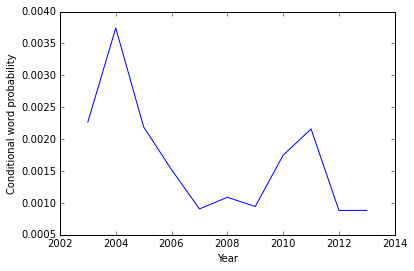

In [14]:
years, freqs = zip(*[(year, counts.prob('organism'))
                      for year, counts   # sorted() sorts by `key`.
                      in sorted(word_probs_over_time.items(), 
                                key=lambda i: i[0])])   # Uses year as key.

plt.plot(years, freqs)
plt.ylabel('Conditional word probability')
plt.xlabel('Year')
plt.show()

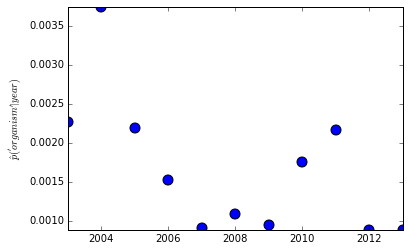

In [19]:
X, Y = zip(*[(year, word_probs_over_time[year].prob('organism')) 
             for year in word_probs_over_time.conditions()])

plt.scatter(X, Y, s=100)    # Create a scatterplot.
plt.ylim(min(Y), max(Y))    # Scale the Y axis.
plt.xlim(min(X), max(X))
plt.ylabel('$\\hat{p}(\'organism\'|year)$')
plt.show()

^Beta: -0.000163374366375
^Beta_0: 0.329722373929
r-squared: 0.37234130934
p: 0.0461889764899


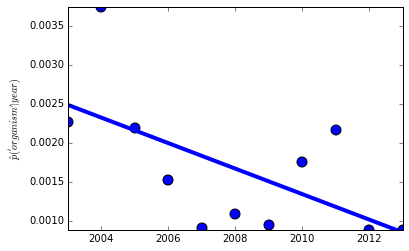

In [22]:
from scipy.stats import linregress
Beta, Beta0, r, p, stde = linregress(X, Y)

print '^Beta:', Beta
print '^Beta_0:', Beta0
print 'r-squared:', r*r
print 'p:', p

plt.scatter(X, Y, s=100)    # Create a scatterplot.
plt.plot(X, [Beta0 + Beta*x  for x in X], lw=4)
plt.ylim(min(Y), max(Y))    # Scale the Y axis.
plt.xlim(min(X), max(X))
plt.ylabel('$\\hat{p}(\'organism\'|year)$')
plt.show()

In [24]:
# We can use underscores `_` for values that we don't want to keep.
Beta_samples, Beta0_samples, _, _, _ = zip(*[linregress(X, np.random.permutation(Y)) 
                                             for i in xrange(1000)])

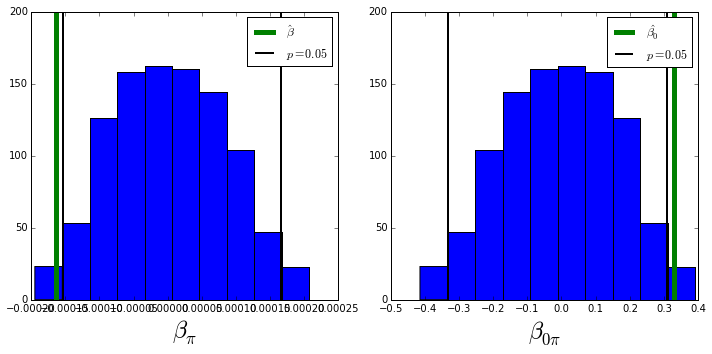

In [25]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.hist(Beta_samples)    # Histogram of Beta values from permutations.
plt.plot([Beta, Beta], [0, 200],     # Beta from the observed data.
         lw=5, label='$\\hat{\\beta}$')

# Plot the upper and lower bounds of the inner 95% probability.
Beta_upper, Beta_lower = np.percentile(Beta_samples, 97.5), np.percentile(Beta_samples, 2.5)
plt.plot([Beta_upper, Beta_upper], [0, 200], color='k', lw=2, label='$p = 0.05$')
plt.plot([Beta_lower, Beta_lower], [0, 200], color='k', lw=2)

plt.legend()
plt.xlabel('$\\beta_{\\pi}$', fontsize=24)

# Same procedure for Beta0.
plt.subplot(122)
plt.hist(Beta0_samples)
plt.plot([Beta0, Beta0], [0, 200], lw=5, label='$\\hat{\\beta_0}$')

Beta0_upper, Beta0_lower = np.percentile(Beta0_samples, 97.5), np.percentile(Beta0_samples, 2.5)
plt.plot([Beta0_upper, Beta0_upper], [0, 200], color='k', lw=2, label='$p = 0.05$')
plt.plot([Beta0_lower, Beta0_lower], [0, 200], color='k', lw=2)

plt.legend()
plt.xlabel('$\\beta_{0\\pi}$', fontsize=24)
plt.tight_layout()
plt.show()